# Определение возраста покупателей методами машинного зрения

## Введение

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Задача построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении есть набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread,imshow
import pandas as pd
import os

In [2]:
path = '...'

In [3]:
df = pd.read_csv(path+'labels.csv')

display(df.head())
df.info()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
print('Пропуски:')
print(df.isna().sum())

Пропуски:
file_name    0
real_age     0
dtype: int64


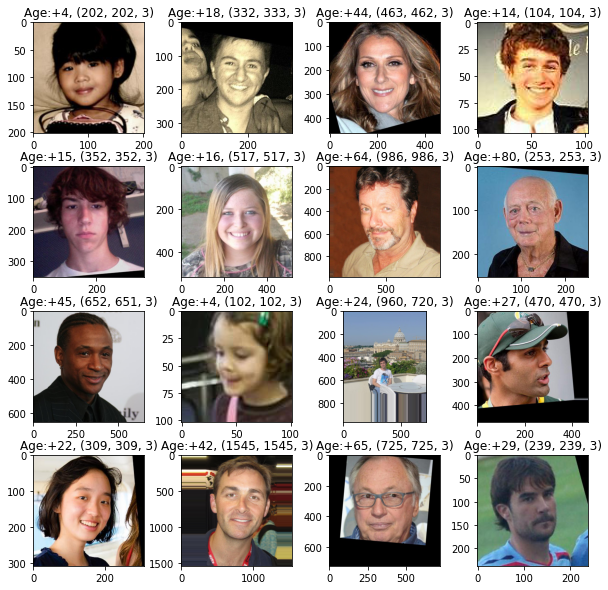

In [5]:
n = 16
show = df.sample(n).reset_index()
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(
                    wspace= 0.3, 
                    hspace=0.3)
for i,r in show.iterrows():
    plt.subplot(4,4,i+1)
    img = imread(path+'final_files/'+r['file_name'])
    plt.title('Age:+'+str(r['real_age'])+', '+str(img.shape))
    imshow(img)#, cmap=plt.get_cmap('gray'))

Как видно все изображения квадратные, но их размер заметно гуляет примерно от 84  до 1000 пикселей.

По-видимому к изображениям примена как минимум аугментация кропа и поворота. Направление лица различно, размер лиц приблизительно одинаков, но встречаются исключения

In [6]:
sizes = []
# Для ускорения рассчетов рассмотрим лишь выборку и будем надеяться что она репрезентативна
for i,r in df.sample(1000).iterrows():
    img = imread(path+'final_files/'+r['file_name'])
    sizes.append(img.shape[0])
    
sizes = pd.Series(sizes)

#sizes.hist()

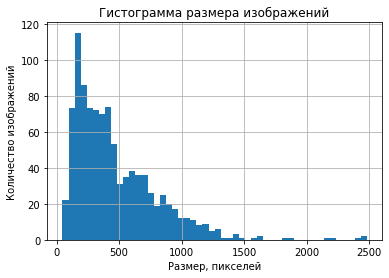

In [7]:
sizes.hist(bins=50)
plt.title('Гистограмма размера изображений')
plt.xlabel('Размер, пикселей')
plt.ylabel('Количество изображений')
plt.show()

Как видно большинство изображений имеет размер около 200 пикселей

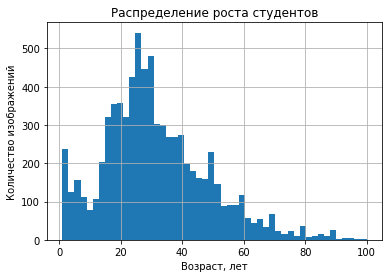

In [8]:
df['real_age'].hist(bins=50)
plt.title('Распределение роста студентов')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество изображений')
plt.show()

Распределение возраста бимодальное с максимумами около 3 и 25 лет.

### Выводы по исследовательскому анализу

Датасет содержит 7591 изображение с указанием возраста. Для обучения модели с нуля этого недостаточно, но для дообучения предобученной модели должно быть достаточно.

Изображения в датасете квадратные с раазмером меняющимся приблизительно от 100 до 2500 пикселей, при этом большинство изображений имеет размер около 200 пикселей.

Лица на изображениях занимают около 1/3 от ширины и высоты изоражений, но встречаются аномалии где лицо очень мелкое. Направление взгляда различное.

Заметно что к датасету применены аугментации кропа, поворота и, возможно, вертикального отражения. Дополнительно также можно применить аугментации поворота (до 30°) и вертикального отражения. Использование кропа и зума нежелательно во избежание сильного изменения размера лиц в датасете (при практическом применении проще на этапе поиска лиц обрезать изображения до нужного размера).

Распределение возраста бимодальное с максимумами около 3 и 25 лет. По-видимому датасет собирался из произвольных фото людей в интернете и так совпало что количество фото с детьми велико. За исключением этого пика распределение можно считать близким к реальному распределению возраста.

С практической точки зрения дошкольники не особо интересны магазину (исключение - определить что у покупателя есть дети).

Также хотелось бы видеть больший объем данных для возраста 15-20 лет, т.к. определение совершеннолетия является одной из задач нейросети и важна точность в данной области.

Малый объем фото пенсионеров не принципиален, знание точного возраста не принесет много информации бизнесу, достаточно приблизительной оценки

В идеале для оценки точности модели использовать метрику с весами для различного возраста для понимания как хорошо модель справляется с предсказаниями именно для интересующих областей.

## Обучение модели

В качестве базовой модели был выбран ResNet50, как относительно универсальная многослойная сверточная сеть для изображений.
Размер входных данных 224x224x3 (стандартный для ResNet50), аугментация не используется.

Целевым признаком сети является возраст (задача регрессии), поэтому на выходе сети стоят 3 полносвязных слоя с активацией ReLU.

В качестве функции потерь выбрана MSE, а метрика MAE, оптимизатор Adam со скоростью обучения 0.0003 (подобрана экспериментально)

```python

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import os
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50, ResNet152, ResNet101
from keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D


def load_train(path):
    try:
        #train_datagen = ImageDataGenerator(rescale=1/255.,validation_split=0.2)
        train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)
        df = pd.read_csv(path+'labels.csv')
    
        train_datagen_flow = train_datagen.flow_from_dataframe(
        df,
        directory=path+'final_files',
        x_col='file_name',
        y_col='real_age',
        #target_size=(224, 224),
        batch_size=32, # можно себе позволить раз GPU позволяет
        subset='training',
        class_mode="other",
        seed=12345)
        #print(next(train_datagen_flow.shape))
        #print(train_datagen_flow.shape)
        return train_datagen_flow
    except Exception as e: print(e)

def load_test(path):
    try:
        #test_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)
        test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)
        df = pd.read_csv(path+'labels.csv')
        
        test_datagen_flow = test_datagen.flow_from_dataframe(
        df,
        directory=path+'final_files',
        x_col='file_name',
        y_col='real_age',
        #target_size=(224, 224),
        batch_size=32,
        subset='validation',
        class_mode="other",
        seed=12345)

        return test_datagen_flow
    except Exception as e: print(e)


def create_model(input_shape):
    try:
        optimizer = Adam(lr=0.0003)
        model = Sequential()
        backbone = ResNet50(input_shape=(224, 224, 3),
                     #weigths=None,
                    include_top=False)
        #backbone.trainable = False
    
        model.add(backbone)
        model.add(GlobalAveragePooling2D())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(1, activation='relu')) 

        model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

        return model
    except Exception as e:
        print('create')
        print(e)


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    try:
        if steps_per_epoch is None:
            steps_per_epoch = len(train_data)
        if validation_steps is None:
            validation_steps = len(test_data)
        model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

        return model
    except Exception as e:
        print('train')
        print(e)



```

```

Epoch 1/10
190/190 - 60s - loss: 183.4954 - mean_absolute_error: 10.0143 - val_loss: 290.9670 - val_mean_absolute_error: 13.4748
Epoch 2/10
190/190 - 49s - loss: 79.6858 - mean_absolute_error: 6.7505 - val_loss: 192.2082 - val_mean_absolute_error: 10.9392
Epoch 3/10
190/190 - 49s - loss: 47.2471 - mean_absolute_error: 5.2618 - val_loss: 71.8588 - val_mean_absolute_error: 6.5715
Epoch 4/10
190/190 - 50s - loss: 28.1338 - mean_absolute_error: 4.0823 - val_loss: 77.1304 - val_mean_absolute_error: 6.8891
Epoch 5/10
190/190 - 50s - loss: 20.3364 - mean_absolute_error: 3.4845 - val_loss: 70.2443 - val_mean_absolute_error: 6.4544
Epoch 6/10
190/190 - 50s - loss: 14.9838 - mean_absolute_error: 2.9798 - val_loss: 65.1411 - val_mean_absolute_error: 6.1069
Epoch 7/10
190/190 - 49s - loss: 11.7373 - mean_absolute_error: 2.6093 - val_loss: 71.6177 - val_mean_absolute_error: 6.3352
Epoch 8/10
190/190 - 49s - loss: 10.2294 - mean_absolute_error: 2.4379 - val_loss: 73.6738 - val_mean_absolute_error: 6.2847
Epoch 9/10
190/190 - 49s - loss: 9.0176 - mean_absolute_error: 2.2639 - val_loss: 64.8372 - val_mean_absolute_error: 6.0454
Epoch 10/10
190/190 - 49s - loss: 8.3394 - mean_absolute_error: 2.1818 - val_loss: 64.6345 - val_mean_absolute_error: 6.0071
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 10s - loss: 64.6345 - mean_absolute_error: 6.0071
Test MAE: 6.0071
```

## Анализ обученной модели

По итогу 10 эпох точность сети достигла 6.01 MAE на тестовой выборке и 2.18 на тренировочной. Таким образом нейросеть является переобученной, но это нормально для многослойной сети.

Число эпох является избыточным и требумый результат 8 MAE был достигнут на 3 эпохе, обучение дальше 10 эпохи бессмысленно т.к. практически не повышаает точность.

Как отмечалось ранее, модель обучалась на данных с лицами примерно одинакового размера и с различным направлением взгляда. Таким образом ее можно использовать для определения возраста людей на фото даже если их взгляд не направлен прямо в камеру, однако требуется предварительная обработка исходных больших изображений: необходимо найти все лица на изображении (например каскадом Хаара) и обрезать до необходимого размера.

Применение модели для определения совершеннолетия нецелесообразно, слишком маленькая точность (MAE 6 лет, а необходима чуть ли не точность до месяцев).

## Выводы

В работе была построена модель для определения возраста человека по изображению. 
Требуемая точность 8 по метрики MAE была достигнута

Модель обучалась на данных с лицами примерно одинакового размера и с различным направлением взгляда. Таким образом ее можно использовать для определения возраста людей на фото даже если их взгляд не направлен прямо в камеру, однако требуется предварительная обработка исходных больших изображений: необходимо найти все лица на изображении (например каскадом Хаара) и обрезать до необходимого размера.

Применение модели для определения совершеннолетия нецелесообразно, слишком маленькая точность (MAE 6 лет, а необходима чуть ли не точность до месяцев).